In [30]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse.linalg import eigsh, expm_multiply, expm

### Correlator generalized for L sites

In [31]:
def gen_spin_operators(L):
    """Returns the spin-1/2 operators sigma_x and sigma_z for L sites."""
    X = sparse.csr_array(np.array([[0.,1.],[1.,0.]]))
    Z = sparse.csr_array(np.diag([1.,-1.]))
    
    d = 2
    Sx_list = []
    Sz_list = []
    
    for i_site in range(L):
        # ops on first site
        if i_site == 0: 
            Sx = X
            Sz = Z 
        else: 
            Sx = sparse.csr_array(np.eye(d))
            Sz = sparse.csr_array(np.eye(d))
        # ops on remaining sites
        for j_site in range(1, L):
            if j_site == i_site: 
                Sx = sparse.kron(Sx, X, 'csr')
                Sz = sparse.kron(Sz, Z, 'csr')
            else:
                Sx = sparse.kron(Sx, np.eye(d), 'csr')
                Sz = sparse.kron(Sz, np.eye(d), 'csr')
        Sx_list.append(Sx)
        Sz_list.append(Sz)
    
    return Sx_list, Sz_list

def gen_hamiltonian_terms(L, Sx_list, Sz_list):
    """Generates the XX and Z terms of the Hamiltonian."""
    D = Sx_list[0].shape[0]
    print(f'System with {L:d} sites, Hilbert space dimension is {D:d}.')

    # Ising interaction
    Hxx = Sx_list[0] @ Sx_list[1]
    for i in range(1, L-1):
        Hxx += Sx_list[i] @ Sx_list[i+1]
    
    # onsite field terms
    Hz = Sz_list[0]
    for Sz in Sz_list[1:L]:
        Hz += Sz
    
    return Hxx, Hz

In [32]:
# define Hamiltonian terms
L = 11
J = 1.
g = 2.    


Sx_list, Sz_list = gen_spin_operators(L)
Hxx, Hz = gen_hamiltonian_terms(L, Sx_list, Sz_list)

H = -J * Hxx -g * Hz

System with 11 sites, Hilbert space dimension is 2048.


In [33]:
# compute correlator
dt = 1e-2
n = 10
N = 2**n

# get ground state
E, psi = eigsh(H, k=1, which='SA')
E0, psi = np.squeeze(E), np.squeeze(psi)
print('Ground state energy:', E0)
psi_0 = psi.copy()

# put in excitation
psi = Sx_list[L//2] @ psi
E1 = np.dot(psi.conj(), H @ psi).real
print('Excited state energy:', E1)

psil = np.array([Sx_list[l] @ psi_0 for l in range(L)])


# evolve states in time
psis = expm_multiply(-1j * H,
                     psi,
                     start=0,
                     stop=N*dt,
                     num=N,
                     endpoint=False)

# calculate correlators C = <psi| e^iHt X_ell e^-iHt X_L/2 |psi>
Cs = np.einsum('lj, ij -> li', psil.conj(), psis) * np.exp(1j * E0 * np.arange(N) * dt)

Ground state energy: -23.26640793492973
Excited state energy: -19.529530591449653


In [34]:
print(Cs.shape) 
#form is (L,2**n) <-> (X,T)

(11, 1024)


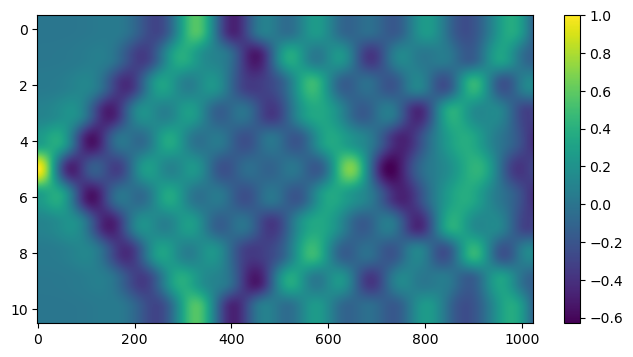

In [35]:
plt.figure(figsize=(8, 4))
plt.imshow(Cs.real, aspect = 'auto', 
           #interpolation = 'none'
           )

plt.colorbar()

In [59]:
import importlib

import sys
sys.path.append('/Users/Giovanni/Desktop/ResearchJob/Student-Research-Job/Chebyshev')
sys.path.append('/Users/Giovanni/Desktop/ResearchJob/Student-Research-Job/TCI')

import Chebyshev as Cbs
import TCI_Lsite as TCI

importlib.reload(Cbs)
importlib.reload(TCI)

<module 'TCI_Lsite' from '/Users/Giovanni/Desktop/ResearchJob/Student-Research-Job/TCI/TCI_Lsite.py'>

### Interpolation with TCI

In [60]:
D = L

func_vals = Cs.T #Cs is in the form (X,T)

#first we define the function f(t)
# which returns the slice of func_vals along x for a specific time 
f_t = lambda *t: Cs.reshape((D,) + (2,) * n)[:,*t]
#here we have to define func as the initialization of the class
func = TCI.function(f_t)

As, _, eval, err_2, err_max, func_interp = TCI.tensor_cross_interpolation(func,         # function to be interpolated
                                   func_vals,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   eps_or_chi=10, # bond dimension
                                   iters=4)       # number of back-and-forth sweeps

print(np.linalg.norm(func_vals), np.max(np.abs(func_vals)))

34.49158952688939 0.9999999999999983


In [61]:
print(err_max)
print(err_2)

7.115745555265198e-05
5.326224300034922e-05


/Users/Giovanni/miniconda3/envs/Computational/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/Giovanni/miniconda3/envs/Computational/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


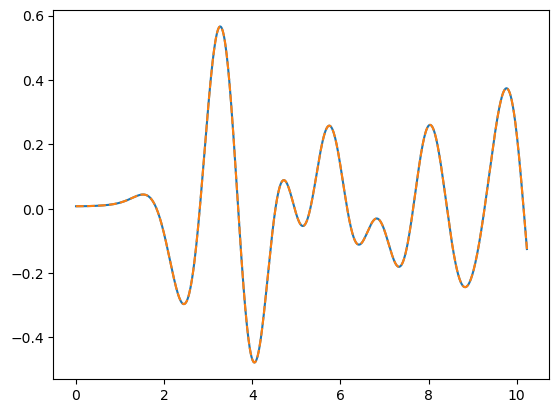

In [39]:
ts = np.arange(N)*dt

plt.plot(ts, func_vals[:,0])
plt.plot(ts, func_interp[:,0], '--')

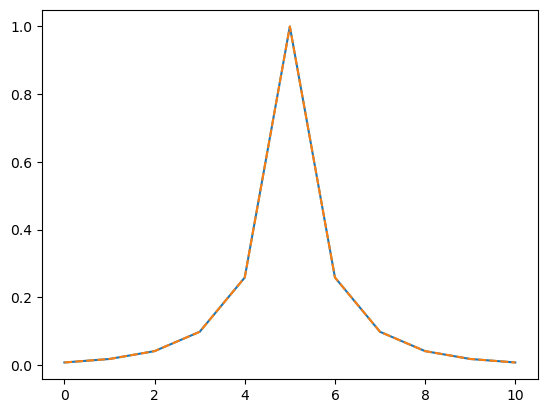

In [40]:
xs = np.arange(L)
plt.plot(xs, func_vals[0,:], "-")
plt.plot(xs, func_interp[0,:], "--")

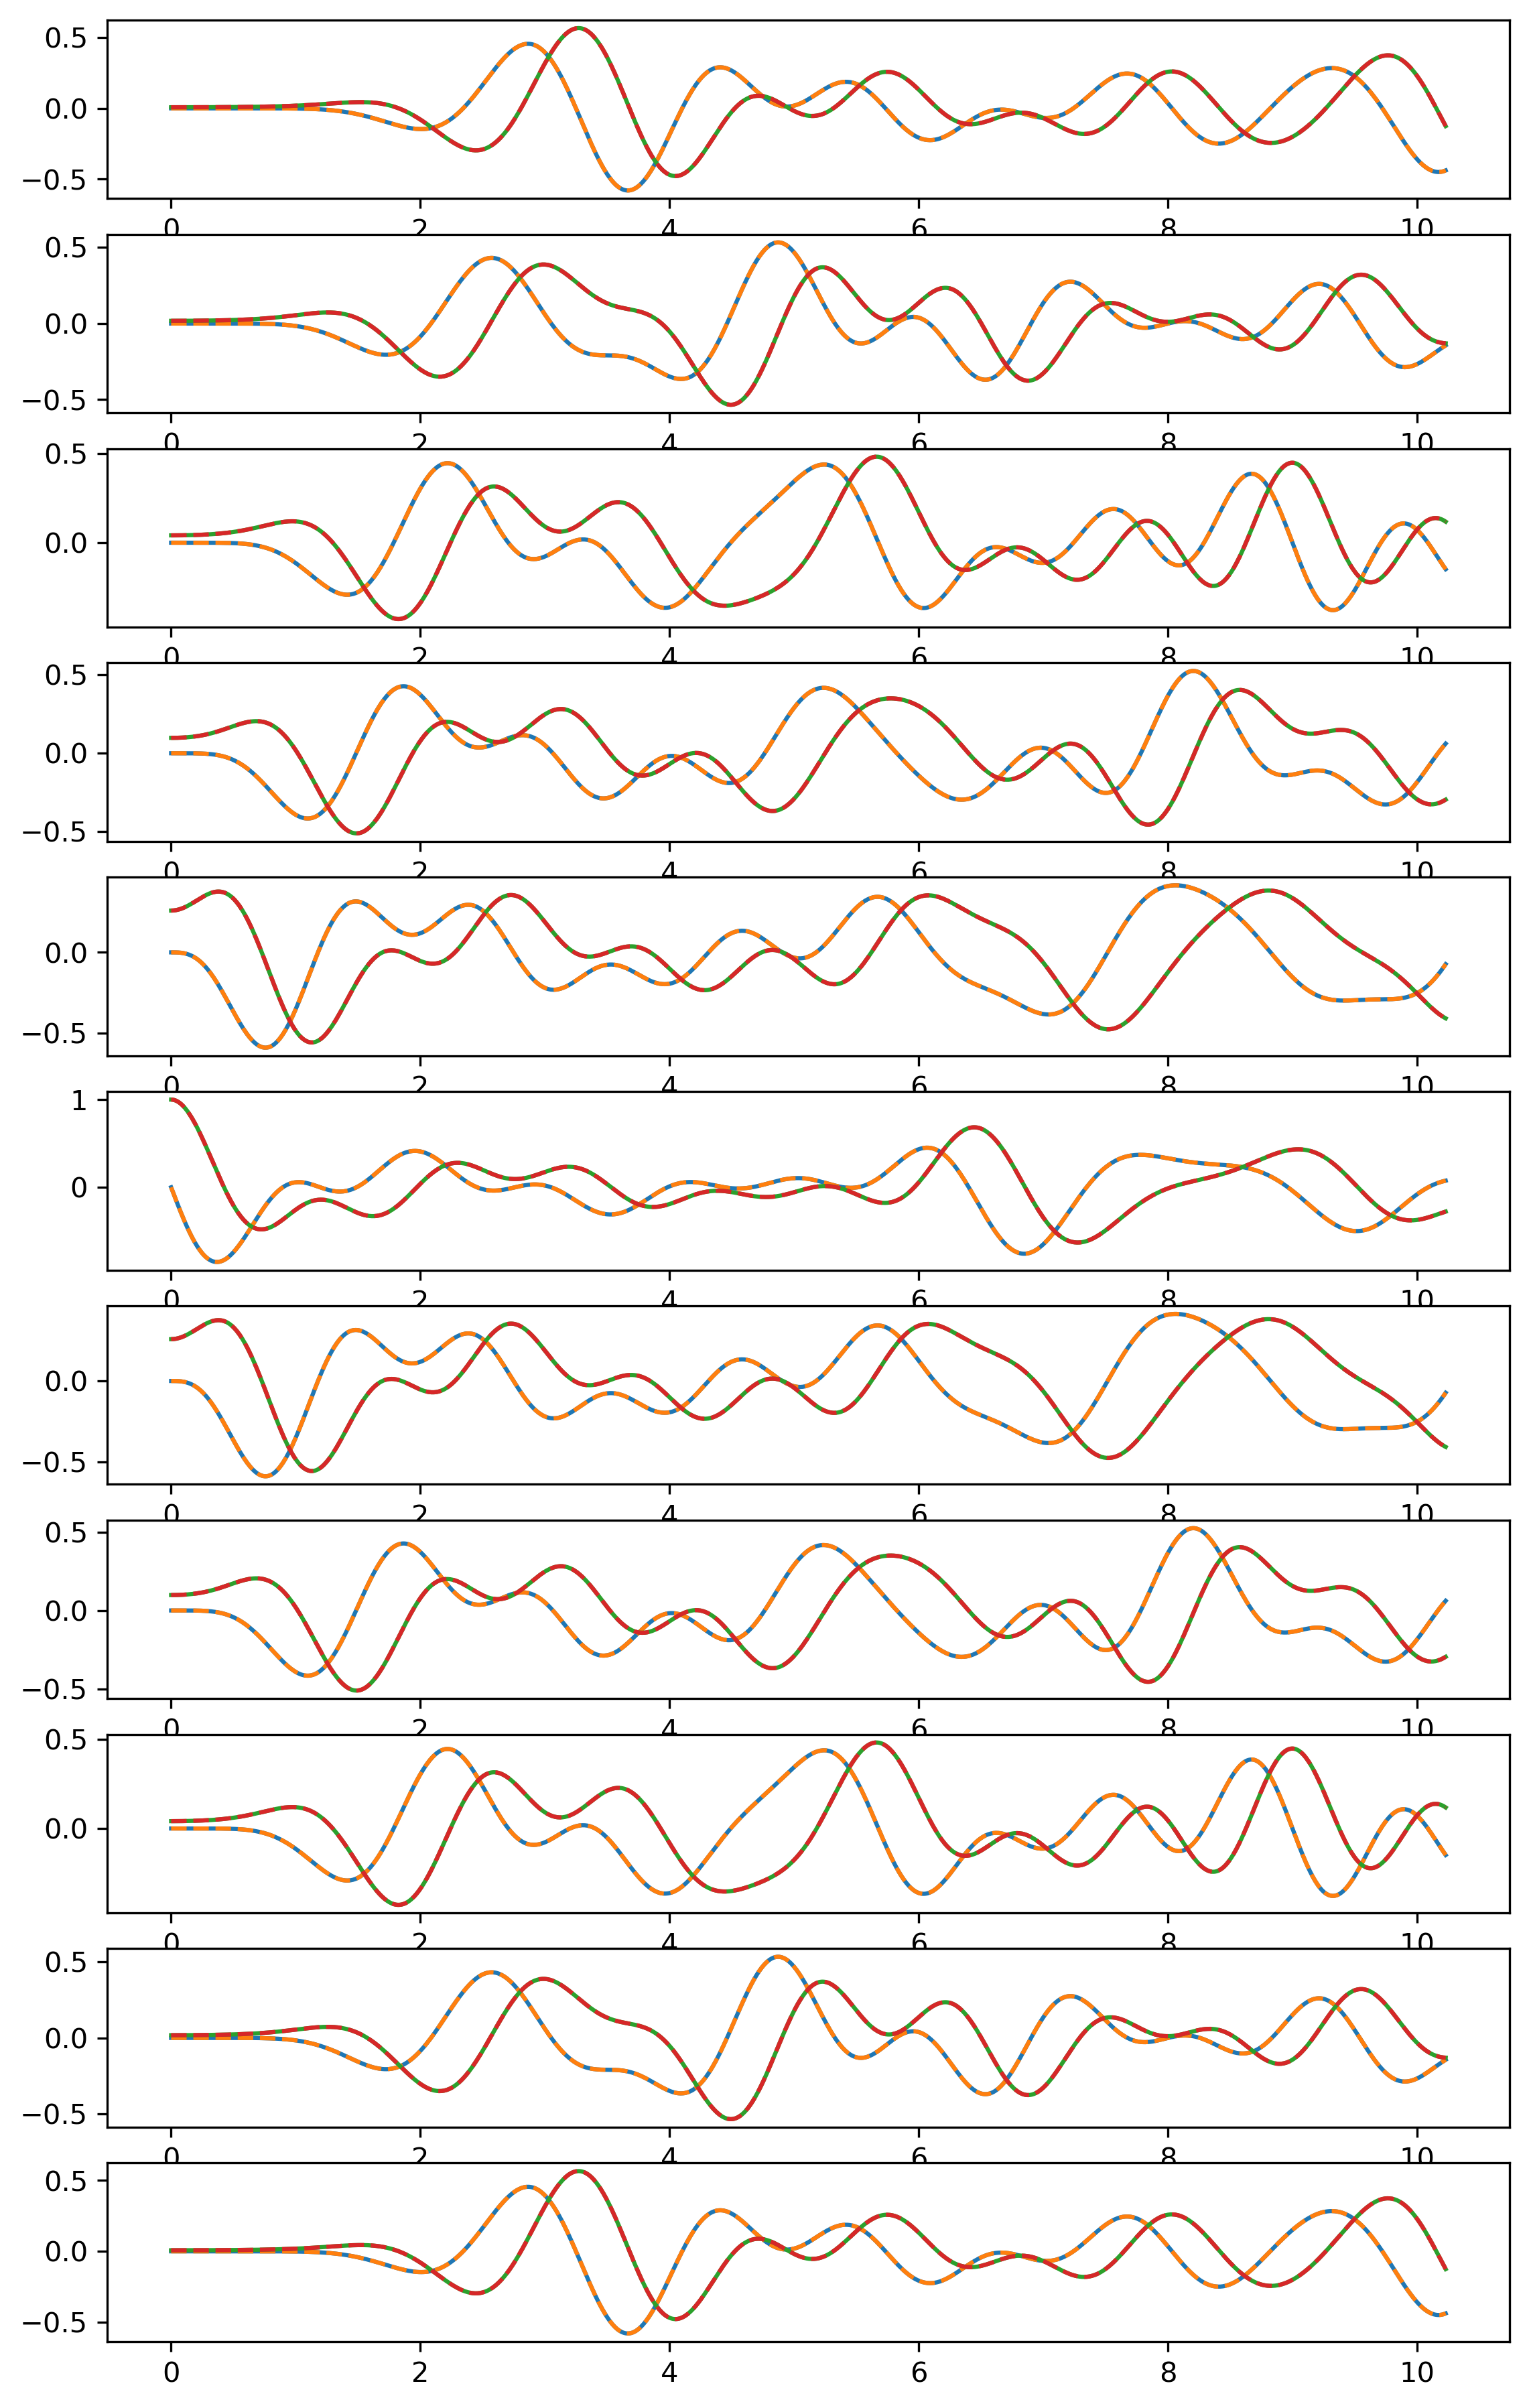

In [41]:
D_list = np.arange(D)

fig, axs = plt.subplots(nrows=D, figsize=(9,15), dpi=300)



for i,item in enumerate(D_list):
    axs[i].plot(ts, np.imag(func_vals[:,item]), '-')
    axs[i].plot(ts, np.imag(func_interp[:,item]), '--')
    axs[i].plot(ts, np.real(func_vals[:,item]), '-')
    axs[i].plot(ts, np.real(func_interp[:,item]), '--')

plt.show()

### Errors vs evaluation for TCI

<>:40: SyntaxWarning: invalid escape sequence '\c'
<>:40: SyntaxWarning: invalid escape sequence '\c'
/var/folders/j2/38n83hh910154cw8rylx28rh0000gq/T/ipykernel_15003/910960079.py:40: SyntaxWarning: invalid escape sequence '\c'
  plt.plot([], [], ' ', label="Numbers: $\chi$ values")  # Dummy plot for chi explanation


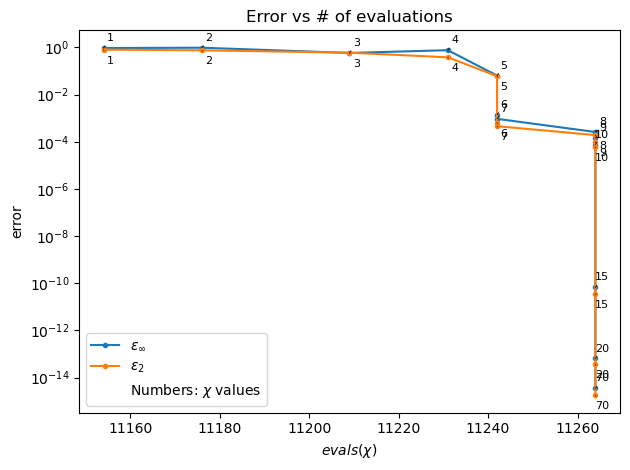

In [42]:
err_max = []
err_2 = []
evals = []
func_interp_list = []

chi_list = [i for i in range(1,10)]
chi_list.extend([i for i in range(10,25,5)])
chi_list.append(70)


for chi in chi_list:
    _, _, eval, err2, errmax, func_interp = TCI.tensor_cross_interpolation(func,         # function to be interpolated
                                   func_vals,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   eps_or_chi=chi, # bond dimension
                                   iters=4)       # number of back-and-forth sweeps
    err_max.append(errmax)
    err_2.append(err2)
    evals.append(eval)
    func_interp_list.append(func_interp)

plt.plot(np.array(evals), np.array(err_max), ".-", label = r"$\epsilon_\infty$")
plt.plot(np.array(evals), np.array(err_2), ".-", label = r"$\epsilon_2$")

# Annotate the points with their chi values
for i, chi in enumerate(chi_list):
    # Annotate error_max (first curve)
    plt.annotate(f"{chi}", (evals[i], err_max[i]),
                 textcoords="offset points", xytext=(5, 5), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')

    # Annotate error_2 (second curve)
    plt.annotate(f"{chi}", (evals[i], err_2[i]),
                 textcoords="offset points", xytext=(5, -10), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')
    
plt.plot([], [], ' ', label="Numbers: $\chi$ values")  # Dummy plot for chi explanation

plt.yscale("log")
plt.xlabel(r"$evals(\chi)$")
plt.ylabel(r"error")
plt.legend()
plt.title("Error vs # of evaluations")
plt.tight_layout()
plt.show()

### Interpolation with Chebyshev

In [46]:
# compute correlator
dt = 1e-2
n = 10
N = 2**n
D = 11


# calculate correlators C = <psi| e^iHt X e^-iHt X |psi>
def Cs_chebyshev_Dsites(D_list, t_matrix):

    D = len(D_list)

    # get ground state
    E, psi = eigsh(H, k=1, which='SA')
    E0, psi = np.squeeze(E), np.squeeze(psi)
    psi_0 = psi.copy()

    # put in excitation
    psi = Sx_list[D//2] @ psi
    E1 = np.dot(psi.conj(), H @ psi).real

    psil = np.array([Sx_list[l] @ psi_0 for l in range(D)])

    a,b = t_matrix.shape

    print(a, b)

    t = t_matrix.reshape(-1)*N*dt
    psis = np.zeros((a*b,psi.shape[0]), dtype=np.complex128)
    for i,tt in enumerate(t):
        psis[i,:] = expm_multiply(-1j * H * tt, psi)
    corr = np.einsum('lj, ij -> li', psil.conj(), psis) * np.exp(1j * E0 * t)
    corr = corr.reshape(D, a, b)
    return corr


# exact function values
#xs = np.linspace(0, N*dt, 2**n, endpoint=False)
ts = np.arange(N)*dt

func_vals = Cs.T

# get MPS from Chebyshev interpolation
chi = 20
As, evals, err_max, err_2, func_interp = Cbs.Chebyshev_interpolation_Dsite(Cs_chebyshev_Dsites, # function to be interpolated
                                 func_vals,
                                 L=n,              # number of MPS tensors
                                 D = D,
                                 chi=chi)           # (half of the) bond dimension



2 20
(1, 11, 2, 20)


In [47]:
print(err_2)
print(err_max)

0.006143628457127581
0.005796130657496062


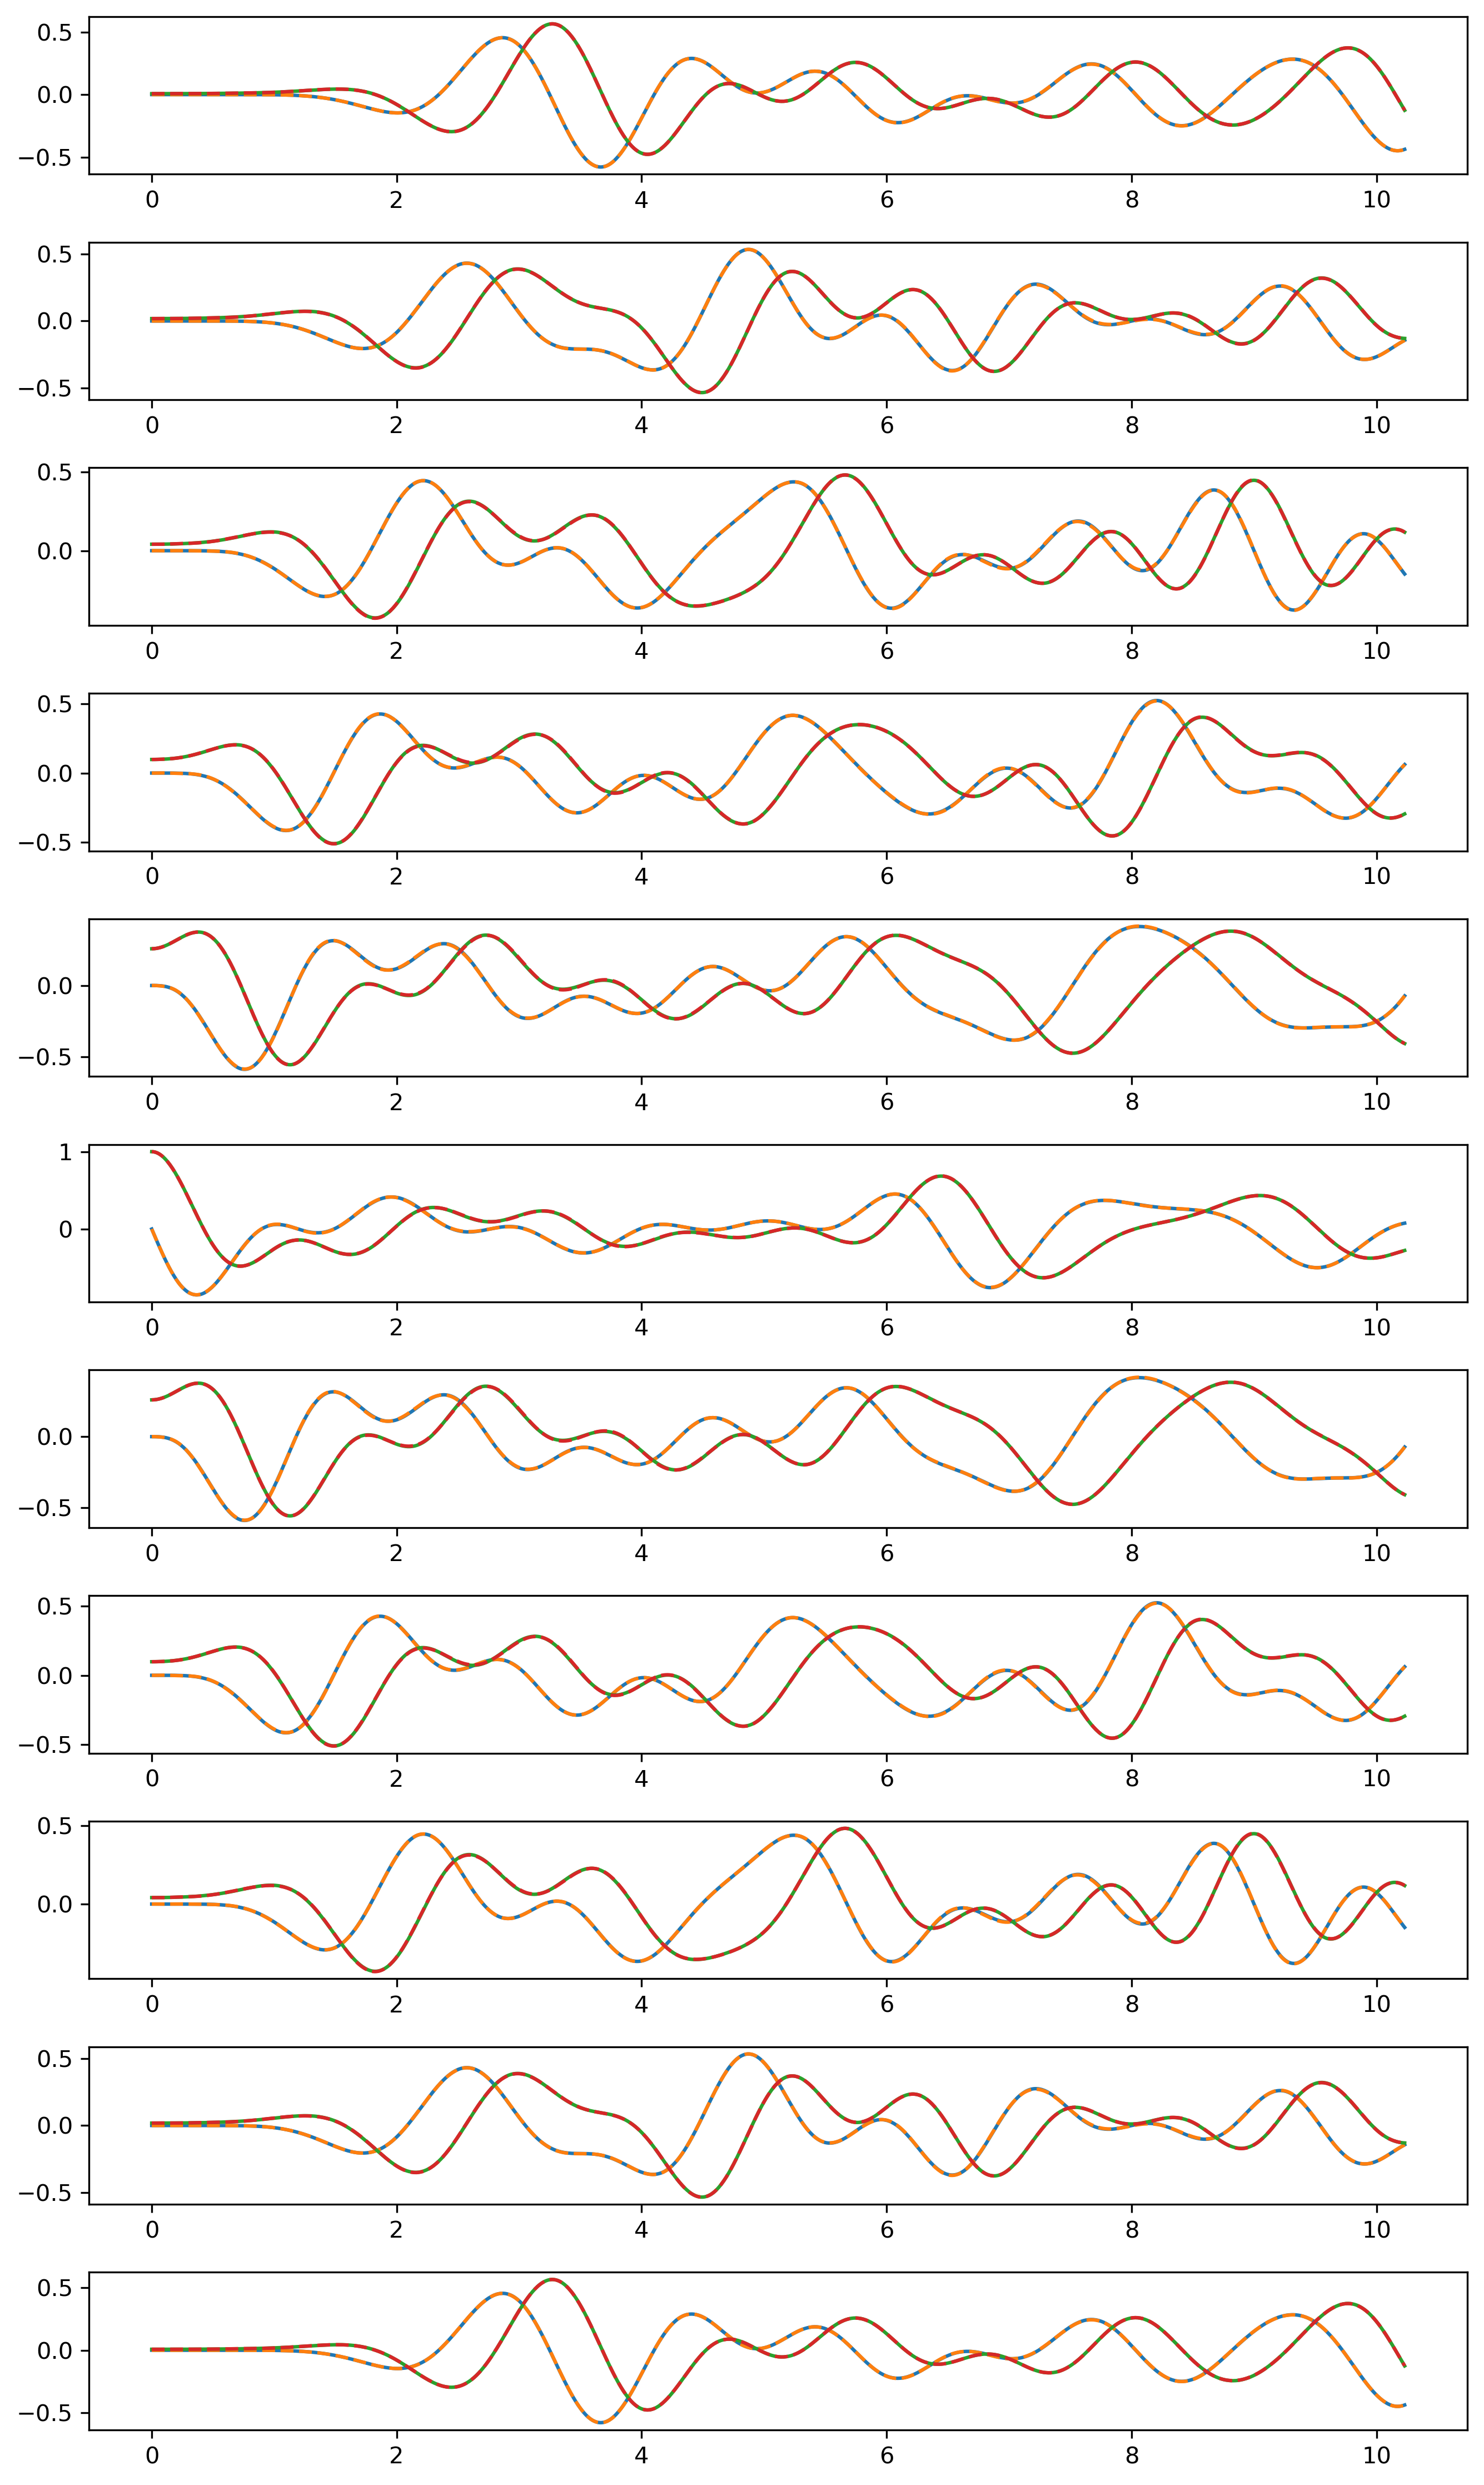

In [48]:
fig, axs = plt.subplots(nrows=D, figsize=(9,15), dpi=300)

D_list = np.arange(D)

for i,item in enumerate(D_list):
    axs[i].plot(ts, np.imag(func_vals[:,item]), '-')
    axs[i].plot(ts, np.imag(func_interp[:,item]), '--')
    axs[i].plot(ts, np.real(func_vals[:,item]), '-')
    axs[i].plot(ts, np.real(func_interp[:,item]), '--')
    #axs[i].set_xlim(0,0.2)

fig.tight_layout()

plt.show()

### Error vs evals for Chebyshev

In [49]:
#here we could define a dictionary to make things more compact
err_max = []
err_2 = []
evals = []
func_interp_list = []

chi_list = [i for i in range(2,10)]
chi_list.extend([i for i in range(10,40,5)])
chi_list.append(70)

for chi in chi_list:
# get MPS from Chebyshev interpolation
    _, eval, errmax, err2, func_interp = Cbs.Chebyshev_interpolation_Dsite(Cs_chebyshev_Dsites, # function to be interpolated
                                 func_vals,
                                 L=n,              # number of MPS tensors
                                 D = D,
                                 chi=chi)           # (half of the) bond dimension

    err_max.append(errmax)
    err_2.append(err2)
    evals.append(eval)
    func_interp_list.append(func_interp)




2 2
(1, 11, 2, 2)
2 3
(1, 11, 2, 3)
2 4
(1, 11, 2, 4)
2 5
(1, 11, 2, 5)
2 6
(1, 11, 2, 6)
2 7
(1, 11, 2, 7)
2 8
(1, 11, 2, 8)
2 9
(1, 11, 2, 9)
2 10
(1, 11, 2, 10)
2 15
(1, 11, 2, 15)
2 20
(1, 11, 2, 20)
2 25
(1, 11, 2, 25)
2 30
(1, 11, 2, 30)
2 35
(1, 11, 2, 35)
2 70
(1, 11, 2, 70)


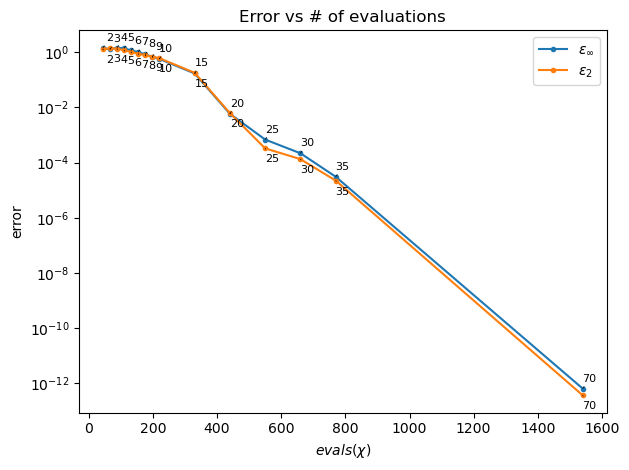

In [50]:
plt.plot(np.array(evals), np.array(err_max), ".-", label = r"$\epsilon_\infty$")
plt.plot(np.array(evals), np.array(err_2), ".-", label = r"$\epsilon_2$")

# Annotate the points with their chi values
for i, chi in enumerate(chi_list):
    # Annotate error_max (first curve)
    plt.annotate(f"{chi}", (evals[i], err_max[i]),
                 textcoords="offset points", xytext=(5, 5), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')

    # Annotate error_2 (second curve)
    plt.annotate(f"{chi}", (evals[i], err_2[i]),
                 textcoords="offset points", xytext=(5, -10), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')
    

plt.yscale("log")
plt.xlabel(r"$evals(\chi)$")
plt.ylabel(r"error")
plt.legend()
plt.title("Error vs # of evaluations")
plt.tight_layout()
plt.show()